# A Critical Evaluation of Causal Effects and Spatial Dynamics through Causal Machine Learning

On the surface, this project seeks to assess the direct impact of Israeli army checkpoints and road barriers within the internal road network of the West Bank on the unemployment rates of Palestinians. Although these obstacles were initially deployed for security purposes, they had consequence of disruption of travel for Palestinian commuters. In other words, Israeli obstacles prevented peri-urban Palestinian commuters from reaching commercial centers and border crossings, causing employment losses for the commuters. However, the adverse effects on employment were largely counterbalanced by increased employment opportunities among centrally located Palestinian competitors. The central argument of the project posits that while minor economic interventions, such as improving road infrastructure, may modify the geographical distribution of unemployment, they are unlikely to bring about an overall reduction in unemployment levels.

## Dataset

In our analysis, we utilized the dataset sourced from the "Hard Traveling" article, which was published by Cambridge University Press. The author, Alexei Sisulu Abrahams, employed a methodology based on the percentage-point change in employment between 1997 and 2007 for various neighborhoods. Abrahams introduced two treatment variables, namely obstruction and protection. Author developed an instrumental variables approach with eveidence that obstacles were deployed to protect Israeli settlements. Since the army intended to protect settlements, obstacle deployment should be predictable by settlement neighborhood. In particular, the army would have enforced defensive buffer zones around settlements, intercepting all Palestinian traffic passing close to settlements. The instrument's exclusion condition is stated as follows: the proximity of Israeli settlements to Palestinian travel routes, while evidently predictive of subsequent blockadedness, should not have affected the evolution of Palestinian neighborhoods’ employment rates via any other causal channel. 

In the data, however, there are 480 neighborhoods, each of which is home to some laborers and some firms; there is no single “business district” neighborhood, and there are few purely residential neighborhoods. Business does tend to concentrate, however, along a central spine of the West Bank in major towns suchas Hebron, Ramallah, Nablus, while most other neighborhoods are small villages and towns that contain a few convenience stores, butcheries, coffee shops, but are largely residential. The author could defensibly define the “business district” as a small set of major towns (the ten governorate capitals, e.g.), which would be equivalent to weighting the commercial importance of these towns as 1 and all other towns as 0.

* Treatment Variables: "Obstruction" quantifies the degree to which Palestinian laborers dwelling at a given census neighborhood are blockaded from accessing jobs at other neighborhoods. "Protection" on the other hand, quantifies the degree to which the laborers of each Palestinian census neighborhood are protected from the inflow or through-flow of competing laborers. In the left panel, a checkpoint obstructs residents of village #1 from accessing jobs in the business district. In the right panel, a checkpoint protects residents of village #1 from the throughflow of competing laborers from village #2 to the business district. Impliciting laborers residing in village #1 are trying to reach the business district; they are not trying to reach village #2 because there are no jobs there.
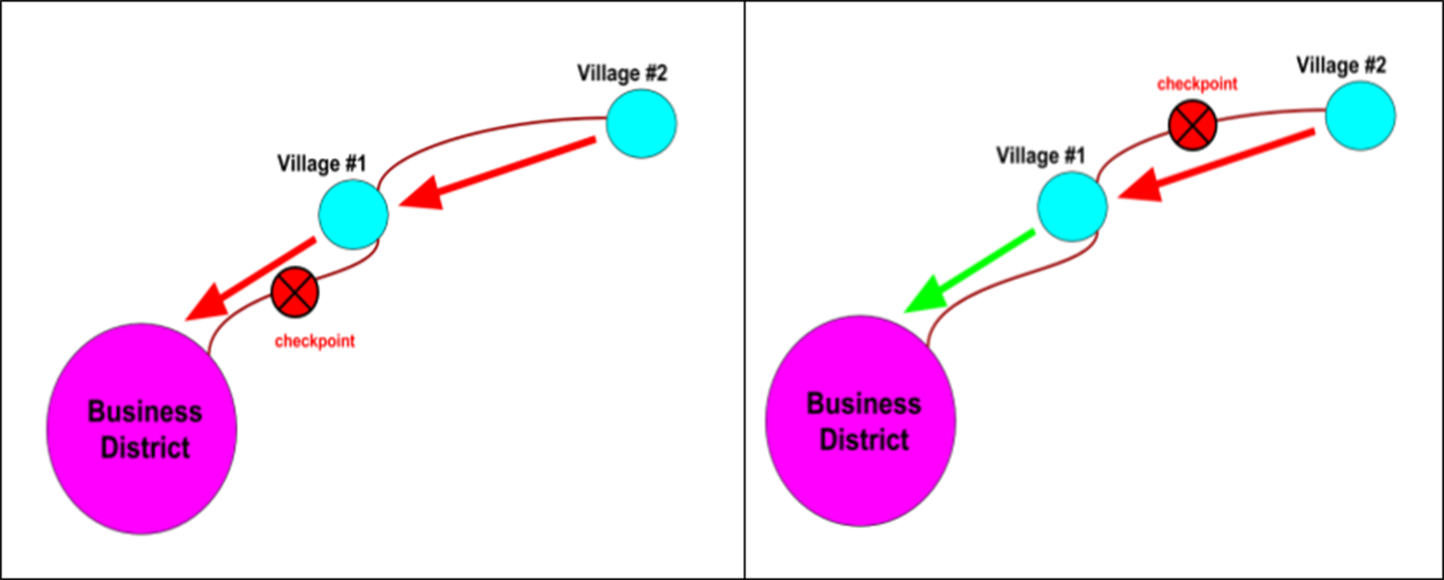

* Instrumental Variables: The instruments ∆iv_obstructionⱼ and ∆iv_protectionⱼ follow the format of the treatment variables, where a ∆iv_obstruction_naiveⱼ is calculated first and ∆iv_obstructionⱼ is weighted by the percent of the Palestinian labour force that works in Israel. With the instruments, however, the effect is not calculated by the number of obstacles, but rather the lengthwise proximity of an Israeli settlement to a commuter path. By assuming a buffer zone around settlements, the proximity is calculated via the total length of the road segments on a commuter path that fall within the buffer zone of a settlement, such that it is representative of potential positioning of a road obstacle. This settlement proximity will have an indirect effect on the % change in employment by virtue of the connection to the placement of Israeli checkpoints. 
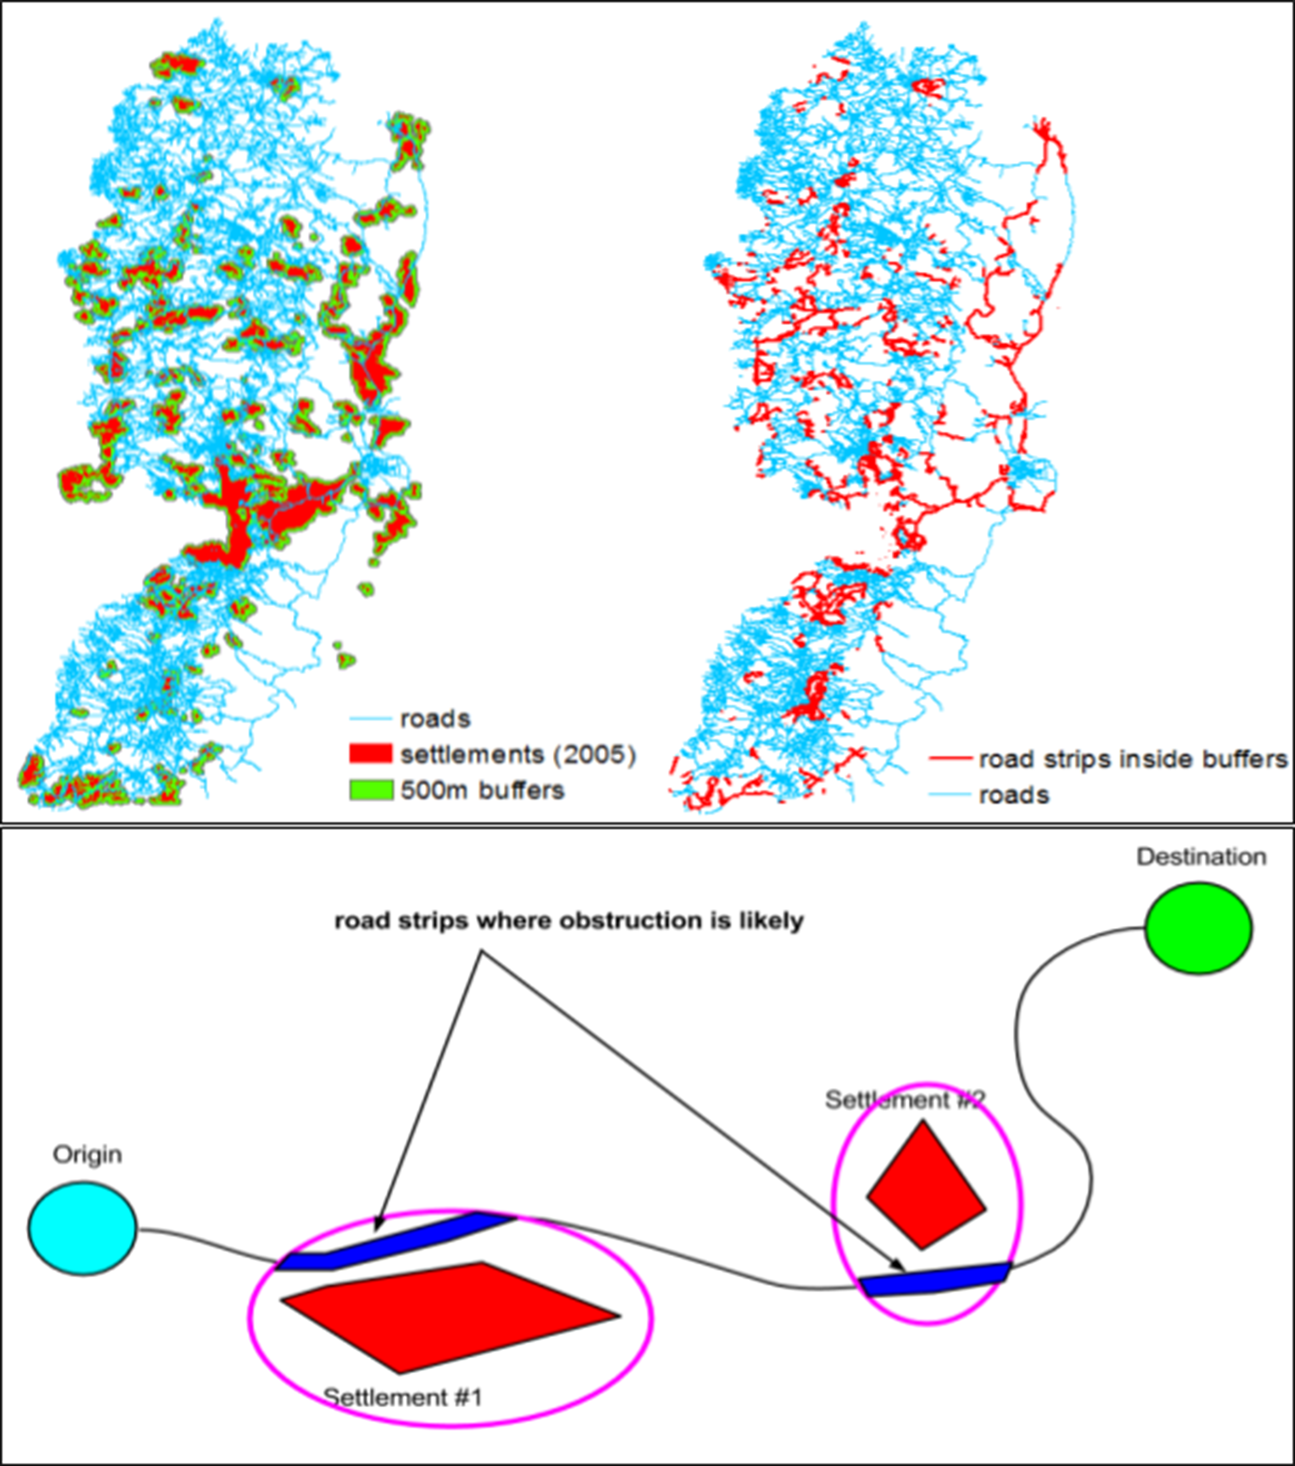

* Covariates: In “Hard traveling “, Abrahams uses 71 covariates in the main regression. Following suit, here we load the 71 controls as dummy variables.

* Outcome: The change in employment rate is our outcome.

## Project Overview

Data scientists have a tendency to focus on descriptive and predictive analysis, but neglect causal analysis. Decision making, however, requires causal analysis. We provided a walkthrough of the conditional average treatment effect (CATE), and suggested that the importance of the CATE is related to equitable policy assignments.The process of causal analysis can be broken down into several stages: the **first step** is to model the causal question, the **second step** is to identify the estimand, the **third step** is to estimate the effect. We also should look at treatment effect heterogeneity.  Understanding the heterogeneity of the treatment effects will help determine whether the results of the study can be extended to support a broader claim of the necessity of political reform. We suspected that there would be a difference in the CATE between the smaller peripheral neighbourhoods and the larger more central neighbourhoods. To test this hypothesis we calculate CATE for both subgroups. The Palestinian neighbourhoods are split along the median of the population totals for all the neighbourhoods, which amounted to a population size of 1885. 

In [4]:
import dowhy
from dowhy import CausalModel
import numpy as np
import pandas as pd
import patsy as ps
import os, sys
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from econml.grf import CausalIVForest
import matplotlib.pyplot as plt
import shap
import geopandas as gpd
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

The obstacles seen in the image were deployed for security reasons, but had the effect of disrupting Palestinian commuter travel. The blue circles are israeli settlements near obstacles

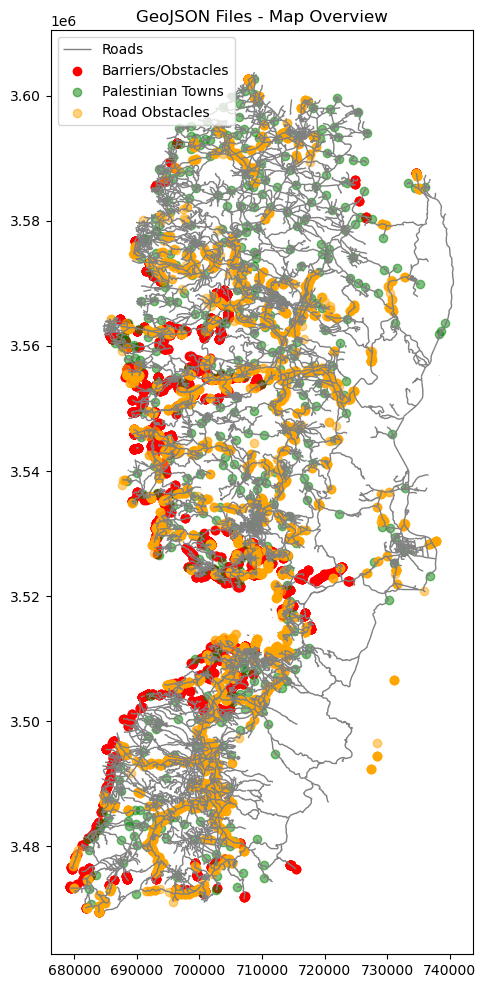

In [5]:
# Load GeoJSON files
barrier_obstacles = gpd.read_file("barrier_obstacles.geojson")
israeli_settlements = gpd.read_file("israeli_settlements.geojson")
plstn_towns = gpd.read_file("plstn_towns.geojson")
road_obstacles = gpd.read_file("road_obstacles.geojson")
roads = gpd.read_file("roads.geojson")

# Plot the GeoJSON files
fig, ax = plt.subplots(figsize=(12, 12))

roads.plot(ax=ax, color='gray', linewidth=1, label='Roads')
barrier_obstacles.plot(ax=ax, color='red', alpha=1, label='Barriers/Obstacles')
# israeli_settlements.plot(ax=ax, color='blue', alpha=0.5, label='Israeli Settlements')
plstn_towns.plot(ax=ax, color='green', alpha=0.5, label='Palestinian Towns')
road_obstacles.plot(ax=ax, color='orange', alpha=0.5, label='Road Obstacles')

# Set legend
ax.legend()

# Set title and show the plot
plt.title('GeoJSON Files - Map Overview')
plt.show()

In the code snippet below, we rename the necessary columns, normalize the variables, and replace NAN values with a “0”.

In [6]:
df = pd.read_stata("C:\\E\\3rd_Semester\\Causal ML\\Project\\hard_traveling_dataset.dta")

df.rename(columns={'oe_bright_30': 'obstruction',
                   'oe_lf_1_bright30': 'protection',
                   'iv_bright_30': 'iv_obstruction',
                   'iv_lf_1_bright30': 'iv_protection'}, inplace=True)

for var in ['obstruction', 'protection', 'iv_obstruction', 'iv_protection']:
    df[var] = df[var]/df[var].mean()

df.replace(np.inf, 0, inplace=True)
df.replace(np.nan, 0, inplace=True)

df[["loc", "x_utm", "y_utm", "point_x", "point_y", "chng_employment"]].head()

loc   x_utm    y_utm      point_x     point_y  chng_employment
0  10005  708667  3602704  708667.2500  3602704.25       -12.208351
1  10010  707202  3600773  707201.7500  3600773.50        -2.262825
2  10015  708673  3600248  708673.2500  3600248.00         8.358406
3  10020  705413  3599766  705413.4375  3599766.00        12.475960
4  10025  722014  3599574  722014.3125  3599573.75         6.001640

here we load the 71 controls as dummy variables.

In [7]:
governorate_dummies = [f"g_{i}" for i in range(0, 11)]
checkpoint_dummies = [f"checkpoint_{i}" for i in range(1, 11)]
partial_checkpoint_dummies = [f"partialcheckpoint_{i}" for i in range(1, 11)]
roadgate_dummies = [f"roadgate_{i}" for i in range(1, 11)]
greenlinecheckpoint_dummies = [f"greenlinecheckpoint_{i}" for i in range(1, 11)] 
earthmound_dummies = [f"earthmound_{i}" for i in range(1, 11)]
settle_dummies = [f"settle_in_{i}km" for i in range(1000, 11000, 1000)]

all_dummies = governorate_dummies + checkpoint_dummies + partial_checkpoint_dummies + roadgate_dummies + greenlinecheckpoint_dummies + earthmound_dummies + settle_dummies

## Causal Graph

DoWhy makes it very simple to build a causal graph. The dataframe is passed to the imported CausalModel, the treatment variables, ∆obstruction and ∆protection, are set, the outcome (dependent) variable is defined as the change in employment, and the instrumental variables ∆iv_obstruction and ∆iv_protection are set. The “common_causes” argument is where we pass all_dummies, this allows us to control for the governorate-level trends and the neighbourhood-level covariates.

DoWhy produces the following causal graph to show the relationships between the independent, dependent and instrumental variables. In the image below, we have excluded the neighbourhood-level covariates since they clutter the diagram. We simply ran the CausalModel without the common causes argument to produce the diagram, but all_dummies are included in the causal model for the rest of the project.

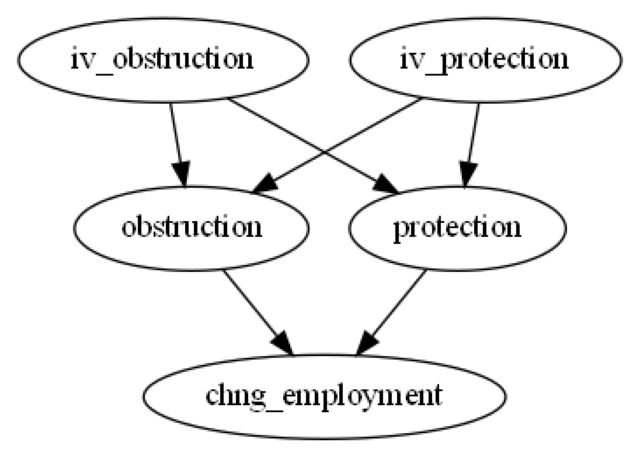

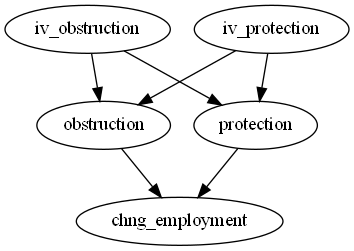

In [8]:
model = CausalModel(
    data=df,
    treatment=['obstruction', 'protection'], 
    outcome='chng_employment',
    instruments=['iv_obstruction', 'iv_protection'] 
)
model.view_model()
display(Image(filename="causal_model.png"))

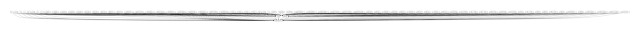

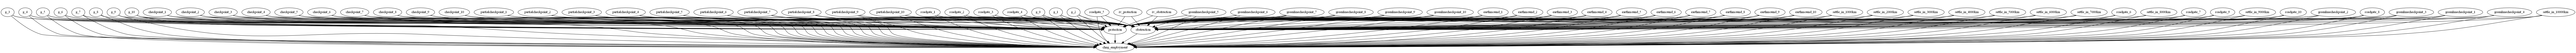

In [19]:
model = CausalModel(
    data=df,
    treatment=['obstruction', 'protection'], 
    outcome='chng_employment', 
    common_causes=all_dummies, 
    instruments=['iv_obstruction', 'iv_protection'], 
)
model.view_model()
display(Image(filename="causal_model.png"))

Model to find the causal effect of treatment ['obstruction', 'protection'] on outcome ['chng_employment']


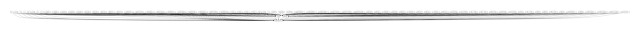

In [20]:
model.interpret()

## Exclusion Condition Assumption:

Estimands are the quantities we want to estimate from our causal model. In this case, we want to find the causal effect of the specified treatment on the outcome. The exclusion condition is an assumption that the instrumental variables (like the proximity of Israeli settlements to Palestinian travel routes) should only predict the blockade (treatment) and should not influence the change in employment through any other way. They should be relevant only to the treatment we are interested in.

From the output we can see If we remove the direct effect of instrumental variables (iv_protection, iv_obstruction) on the treatment variables (obstruction, protection), then the instrumental variables have no direct effect on the change in employment.

In [33]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[chng_employment|partialcheckpoint_2,settle_in_100
d[obstruction  protection]                                                    

                                                                              
0km,settle_in_5000km,g_2,greenlinecheckpoint_6,g_5,partialcheckpoint_10,partia
                                                                              

                                                                              
lcheckpoint_4,settle_in_8000km,partialcheckpoint_3,roadgate_6,g_9,checkpoint_1
                                                                              

                                                                              
0,roadgate_1,roadgate_8,checkpoint_9,iv_protection,checkpoint_5,earthmound_10,
                   

## Causal Machine Learning

Since we are testing the hypothesis that the subgroups experience different CATEs, in the code snippet below we divide the dataset in half using the median value of the population totals (median = 1885). Following that, separate variable (outcome, treatment, covariates, instruments) sets are defined for the two subgroups and converted to numpy arrays to fit the neural networks.

In [9]:
# split dataset by subgroup 
df_per = df[df['population_total']<=1884]
df_not_per = df[df['population_total']>=1885]
# split for train and test sets for each subgroup
train_per, test_per = train_test_split(df_per, test_size=0.2)
train_not_per, test_not_per = train_test_split(df_not_per, test_size=0.2)

treatment = ['obstruction', 'protection']
outcome = ['chng_employment']
covariates = all_dummies 
instruments = ['iv_obstruction', 'iv_protection']

Y = train_per[outcome]
T = train_per[treatment]
X = train_per[covariates]
Z = train_per[instruments]
X_test = test_per[covariates]

Y2 = train_not_per[outcome]
T2 = train_not_per[treatment]
X2 = train_not_per[covariates]
Z2 = train_not_per[instruments]
X2_test = test_not_per[covariates]

Next, we set the parameters for the two causal forests and fit the models.

In [10]:
# set parameters for the causal forest for each subgroup 
est_per = CausalIVForest(criterion='het', 
                     n_estimators=10000,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = False
                     )
est_not_per = CausalIVForest(criterion='het', 
                     n_estimators=10000,       
                     min_samples_leaf=5, 
                     max_depth=None, 
                     max_samples=0.5,
                     honest=True,
                     inference=True,
                     fit_intercept = False
                     )

# fit a causal forest model for each subgroup 
est_per.fit(X, T, y=Y, Z=Z)
est_not_per.fit(X2, T2, y=Y2, Z=Z2)


CausalIVForest(criterion='het', fit_intercept=False, max_samples=0.5,
               n_estimators=10000)

### Spatial Map of Treatment Effects

We want to plot the treatment effect in the vicinity and have the visualization of the relationship between road obstacles and employment rate.

In [11]:
treatment_effects_per, lb_per, ub_per = est_per.predict(X, interval=True, alpha=0.05)
treatment_effects_not_per, lb_not_per, ub_not_per = est_not_per.predict(X2, interval=True, alpha=0.05)

# Create DataFrames with CATE values and corresponding confidence intervals
df_te_per = pd.DataFrame({
    'cate': [treatment_effects_per[i][0] + treatment_effects_per[i][1] for i in range(len(treatment_effects_per))],
    'lb': [lb_per[i][0] + lb_per[i][1] for i in range(len(lb_per))],
    'ub': [ub_per[i][0] + ub_per[i][1] for i in range(len(ub_per))]
}, index=X.index)  # Use X.index to set the same index as the original dataframe

df_te_not_per = pd.DataFrame({
    'cate': [treatment_effects_not_per[i][0] + treatment_effects_not_per[i][1] for i in range(len(treatment_effects_not_per))],
    'lb': [lb_not_per[i][0] + lb_not_per[i][1] for i in range(len(lb_not_per))],
    'ub': [ub_not_per[i][0] + ub_not_per[i][1] for i in range(len(ub_not_per))]
}, index=X2.index)  # Use X2.index to set the same index as the original dataframe


In [12]:
# # Merge the "cate" columns with the original DataFrame based on the index
# Assuming that the indices align
train_per = pd.concat([train_per, df_te_per['cate']], axis=1)
train_not_per = pd.concat([train_not_per, df_te_not_per['cate']], axis=1)

In [13]:
# Concatenate df_per and df_not_per along the rows
df_combined = pd.concat([train_per, train_not_per], ignore_index=True)

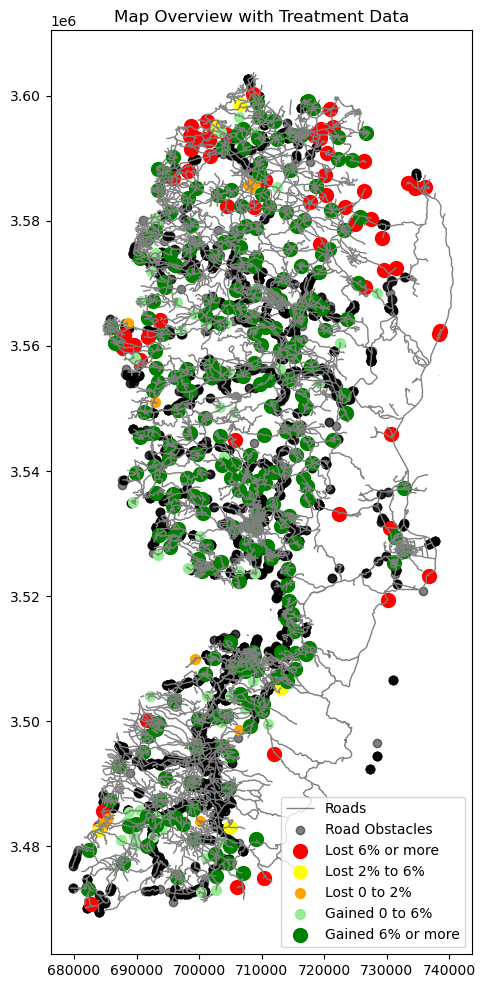

In [14]:
# Categorize change in treatment effects
df_combined['treatment_category'] = pd.cut(df_combined['cate'], bins=[-np.inf, -0.6, -0.2, 0, 0.6, np.inf],
                                   labels=['Neg TE 6% or more', 'Neg TE 2% to 6%', 'Neg TE 0 to 2%', 'Pos TE 0 to 6%', 'Pos TE 6% or more'])

# Load GeoJSON files
# barrier_obstacles = gpd.read_file("barrier_obstacles.geojson")
israeli_settlements = gpd.read_file("israeli_settlements.geojson")
# plstn_towns = gpd.read_file("plstn_towns.geojson")
road_obstacles = gpd.read_file("road_obstacles.geojson")
roads = gpd.read_file("roads.geojson")

# Merge GeoDataFrame with your DataFrame
gdf = gpd.GeoDataFrame(df_combined, geometry=gpd.points_from_xy(df_combined['point_x'], df_combined['point_y']))

# Plot the GeoJSON files and the employment data
fig, ax = plt.subplots(figsize=(12, 12))

roads.plot(ax=ax, color='gray', linewidth=1, label='Roads')
# barrier_obstacles.plot(ax=ax, color='black', alpha=1, label='Barriers/Obstacles')
# israeli_settlements.plot(ax=ax, color='blue', alpha=0.5, label='Israeli Settlements')
# plstn_towns.plot(ax=ax, color='purple', alpha=0.5, label='Palestinian Towns')
road_obstacles.plot(ax=ax, color='black', alpha=0.5, label='Road Obstacles')

# Plot the employment data with different colors based on the category
gdf[gdf['treatment_category'] == 'Neg TE 6% or more'].plot(ax=ax, color='red', marker='o', markersize=100, label='Lost 6% or more')
gdf[gdf['treatment_category'] == 'Neg TE 2% to 6%'].plot(ax=ax, color='yellow', marker='o', markersize=90, label='Lost 2% to 6%')
gdf[gdf['treatment_category'] == 'Neg TE 0 to 2%'].plot(ax=ax, color='orange', marker='o', markersize=50, label='Lost 0 to 2%')
gdf[gdf['treatment_category'] == 'Pos TE 0 to 6%'].plot(ax=ax, color='lightgreen', marker='o', markersize=50, label='Gained 0 to 6%')
gdf[gdf['treatment_category'] == 'Pos TE 6% or more'].plot(ax=ax, color='Green', marker='o', markersize=100, label='Gained 6% or more')

# Set legend
ax.legend()

# Set title and show the plot
plt.title('Map Overview with Treatment Data')
plt.show()

### Different Treatment Effects of Subgroups

Lastly, we plot the different treatment effects and confidence intervals from each causal forest.

In [15]:
treatment_effects_per, lb_per, ub_per = est_per.predict(X, interval=True, alpha=0.05)
treatment_effects_not_per, lb_not_per, ub_not_per = est_not_per.predict(X2, interval=True, alpha=0.05)

te_per = []
for i in range(len(treatment_effects_per)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_per[i][0] + treatment_effects_per[i][1]
    dict_te['lb'] = lb_per[i][0] + lb_per[i][1]
    dict_te['ub'] = ub_per[i][0] + ub_per[i][1]
    te_per.append(dict_te)
df_te_per = pd.DataFrame(te_per)

te_not_per = []
for i in range(len(treatment_effects_not_per)):
    dict_te = {}
    dict_te['cate'] = treatment_effects_not_per[i][0] + treatment_effects_not_per[i][1]
    dict_te['lb'] = lb_not_per[i][0] + lb_not_per[i][1]
    dict_te['ub'] = ub_not_per[i][0] + ub_not_per[i][1]
    te_not_per.append(dict_te)
df_te_not_per = pd.DataFrame(te_not_per)

We use the causal forest models to predict treatment effects and the upper and lower bounds of the confidence intervals, for each subgroup. Following that, the results for each subgroup are stored in a dataframe and the rolling mean is calculated.

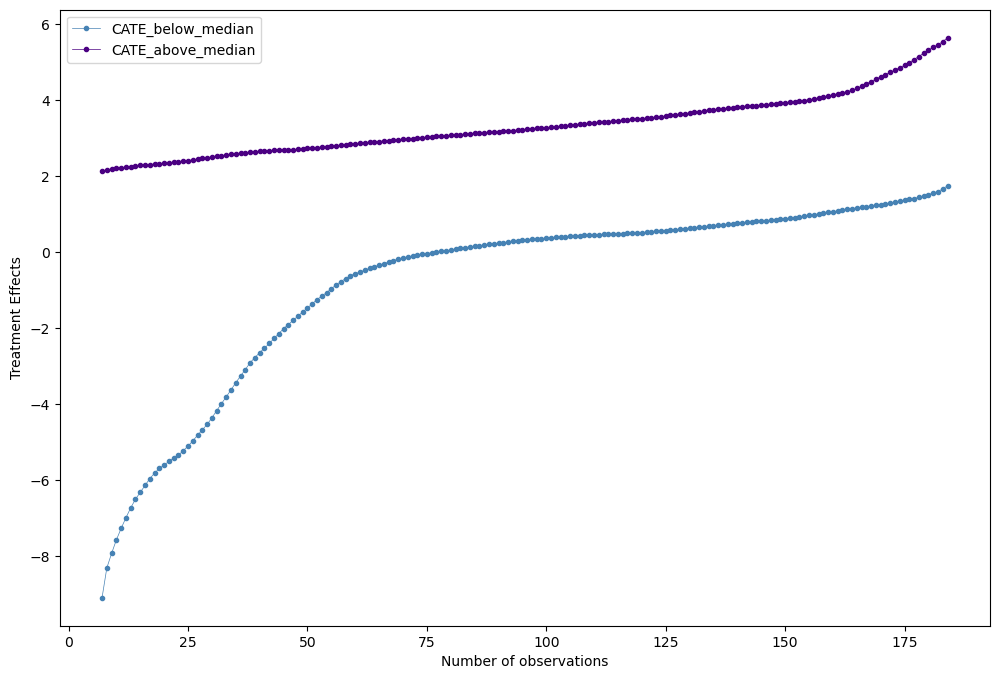

In [16]:
df_te_per.sort_values('cate', inplace=True, ascending=True)
df_te_per.reset_index(inplace=True, drop=True)
z_per = df_te_per.rolling(window=15, center=True).mean()

df_te_not_per.sort_values('cate', inplace=True, ascending=True)
df_te_not_per.reset_index(inplace=True, drop=True)
z_not_per = df_te_not_per.rolling(window=15, center=True).mean()

# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(z_per['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_below_median', color='steelblue')
# uncomment for confidence intervals for peripheral neighbourhoods
# ax.plot(z_per['lb'],
#         marker='.', linestyle='-', linewidth=0.5, color='green')
# ax.plot(z_per['ub'],
#         marker='.', linestyle='-', linewidth=0.5, color='green')
# plot treatment effects for central neighbourhoods
ax.plot(z_not_per['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_above_median', color='indigo')
# uncomment for confidence intervals for central neighbourhoods
# ax.plot(z_not_per['lb'],
#         marker='.', linestyle='-', linewidth=0.5, color='green')
# ax.plot(z_not_per['ub'],
#         marker='.', linestyle='-', linewidth=0.5, color='green')

# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

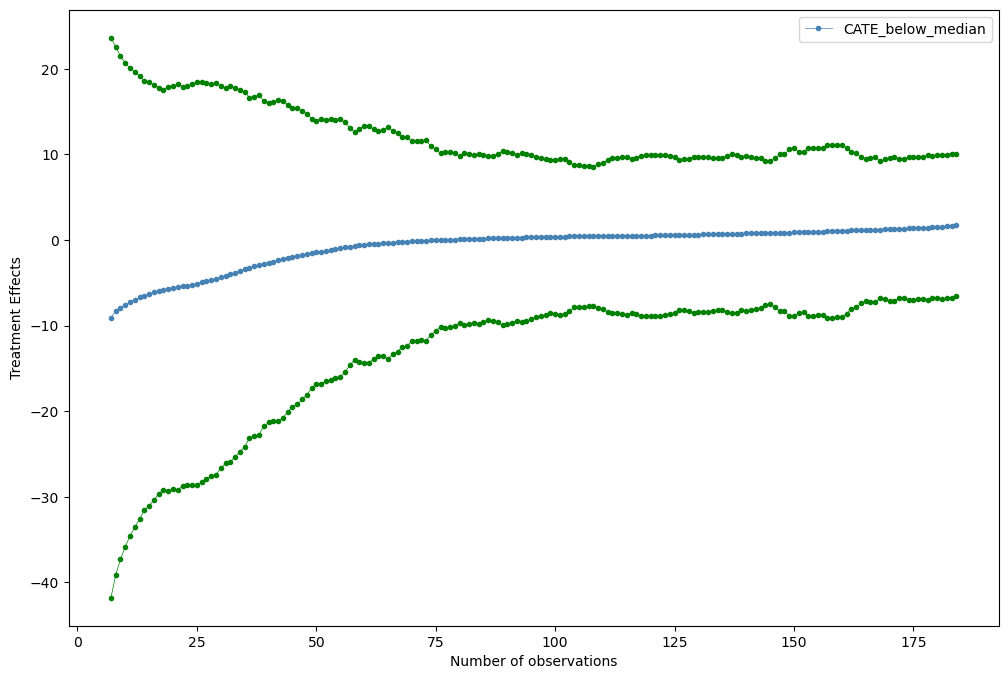

In [17]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for peripheral neighbourhoods
ax.plot(z_per['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_below_median', color='steelblue')
# uncomment for confidence intervals for peripheral neighbourhoods
ax.plot(z_per['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='green')
ax.plot(z_per['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='green')

# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

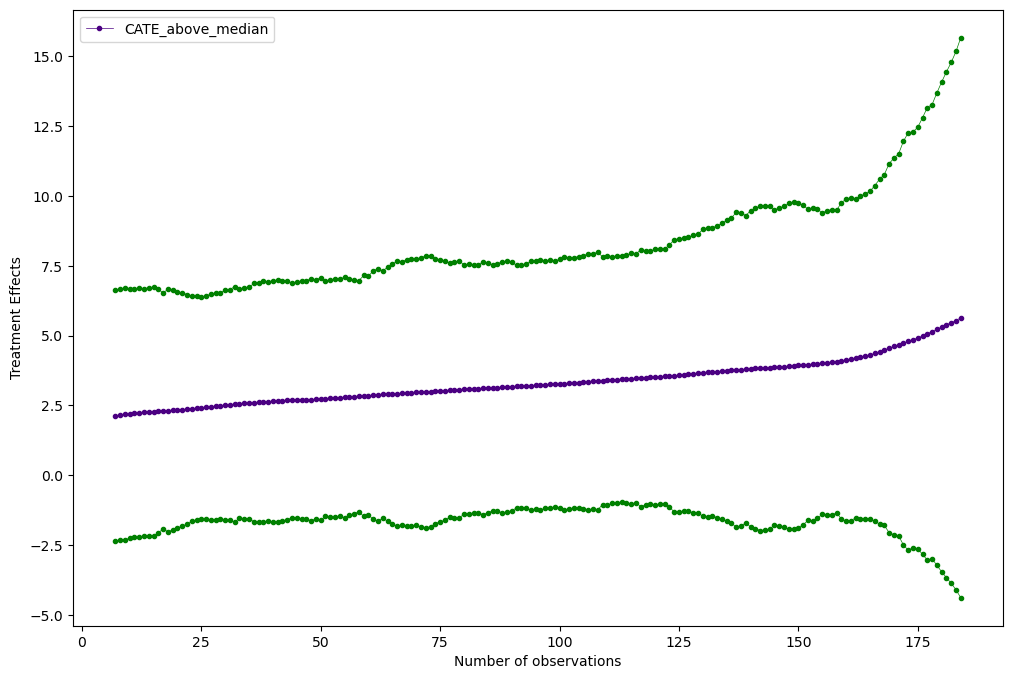

In [18]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))

# plot treatment effects for central neighbourhoods
ax.plot(z_not_per['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE_above_median', color='indigo')
# uncomment for confidence intervals for central neighbourhoods
ax.plot(z_not_per['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='green')
ax.plot(z_not_per['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='green')

# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

## Conclusion

The median CATE for the small peripheral neighbourhoods ranged from 0.2 to 0.3, whereas the median for the larger central neighbourhoods ranged from 2.9 to 3.1. 

A distinct contrast in the CATE values among the subgroups indicates the effectiveness of the initially proposed subgroup divisions. The presence of reliable confidence intervals proves essential for informed policy decisions. The selection of the estimation method, however, should be contingent upon the experiment's objectives and the scale and intricacy of the dataset. In the context of policy assignments, a preference towards causal forest estimates is evident, given their ability to provide a measure of uncertainty associated with these estimates

I want to conclude the project with spatial graph with employment rate variance where the unemployment losses in the peripheral neighbourhoods were in contrast to the employment gains in the central neighbourhoods..

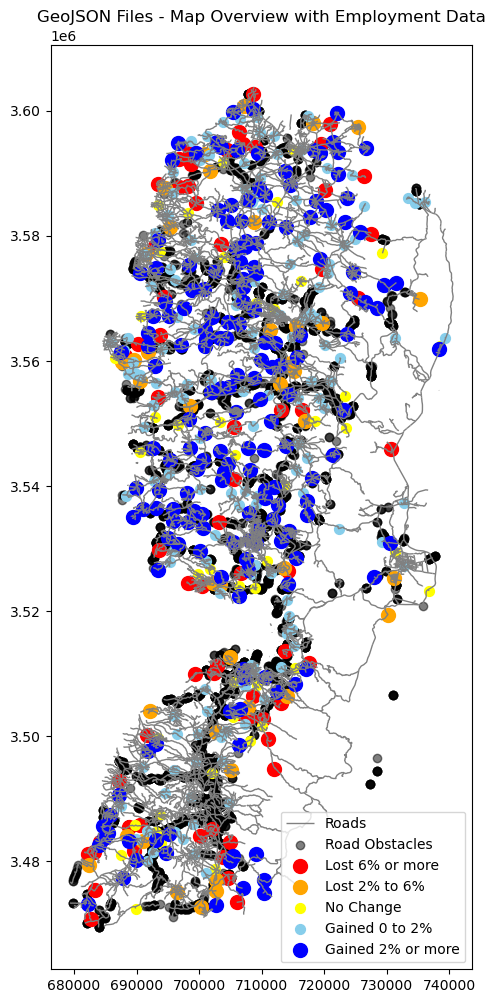

In [21]:
# Categorize change in employment
df['employment_category'] = pd.cut(df['chng_employment'], bins=[-float('inf'), -6, -2, 0, 6, float('inf')],
                                   labels=['Lost 6% or more', 'Lost 2% to 6%', 'Lost 0 to 2%', 'Gained 0 to 6%', 'Gained 6% or more'])

# Load GeoJSON files
# barrier_obstacles = gpd.read_file("barrier_obstacles.geojson")
# israeli_settlements = gpd.read_file("israeli_settlements.geojson")
# plstn_towns = gpd.read_file("plstn_towns.geojson")
road_obstacles = gpd.read_file("road_obstacles.geojson")
roads = gpd.read_file("roads.geojson")

# Merge GeoDataFrame with your DataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['point_x'], df['point_y']))

# Plot the GeoJSON files and the employment data
fig, ax = plt.subplots(figsize=(12, 12))

roads.plot(ax=ax, color='gray', linewidth=1, label='Roads')
# barrier_obstacles.plot(ax=ax, color='red', alpha=1, label='Barriers/Obstacles')
# israeli_settlements.plot(ax=ax, color='blue', alpha=0.5, label='Israeli Settlements')
# plstn_towns.plot(ax=ax, color='green', alpha=0.5, label='Palestinian Towns')
road_obstacles.plot(ax=ax, color='black', alpha=0.5, label='Road Obstacles')

# Plot the employment data with different colors based on the category
gdf[gdf['employment_category'] == 'Lost 6% or more'].plot(ax=ax, color='red', marker='o', markersize=100, label='Lost 6% or more')
gdf[gdf['employment_category'] == 'Lost 2% to 6%'].plot(ax=ax, color='orange', marker='o', markersize=100, label='Lost 2% to 6%')
gdf[gdf['employment_category'] == 'Lost 0 to 2%'].plot(ax=ax, color='yellow', marker='o', markersize=50, label='No Change')
gdf[gdf['employment_category'] == 'Gained 0 to 6%'].plot(ax=ax, color='skyblue', marker='o', markersize=50, label='Gained 0 to 2%')
gdf[gdf['employment_category'] == 'Gained 6% or more'].plot(ax=ax, color='blue', marker='o', markersize=100, label='Gained 2% or more')

# Set legend
ax.legend()

# Set title and show the plot
plt.title('GeoJSON Files - Map Overview with Employment Data')
plt.show()

## Reference
Hard traveling: unemployment and road infrastructure in the shadow of political conflict: https://www.cambridge.org/core/journals/political-science-research-and-methods/article/hard-traveling-unemployment-and-road-infrastructure-in-the-shadow-of-political-conflict/135F8A50F613DA3C9C4CB9335F0BFCF7